## Notebook: Ptychography reconstruction with positions update from a CXI dataset
This notebook uses the the runner API (`pynx.ptycho.runner`) to load the data and prepare the optimisation.

This is what is used for the command-line scripts, here we just grap the Ptycho object from the runner.

This uses a dataset recorded on id01@ESRF, which exhibits some position distortions near the ceneter of the spiral scan.

In [1]:
# Select language and/or GPU name or rank through environment variable (optional)
#import os
#os.environ['PYNX_PU'] = 'cuda.0'  

%matplotlib widget
import matplotlib.pyplot as plt
from pynx.ptycho import simulation, shape

# Import Ptycho, PtychoData and operators (automatically selecting OpenCL or CUDA)
from pynx.ptycho import *

# Import CXI runner
from pynx.ptycho.runner.cxi import PtychoRunnerScanCXI, default_params as params

# This can be used to have a wide screen for the notebook
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:90% !important; }</style>"))

## Load CXI data if necessary
this is available from the PyNX ESRF public folder

In [2]:
if not os.path.exists('ptycho-siemens-star-id01.cxi'):
    os.system('curl -O http://ftp.esrf.fr/pub/scisoft/PyNX/data/ptycho-siemens-star-id01.cxi')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 86.1M  100 86.1M    0     0   904M      0 --:--:-- --:--:-- --:--:--  907M


## Load the data & setup the runner parameters
As we are using the `pynx.ptycho.runner` API, we can setup the parameters exactly as for the command-line scripts.

In [3]:
params['cxifile']='ptycho-siemens-star-id01.cxi'

# Initial probe description
params['probe']='gauss,150e-9x200e-9'  # Starting from a simulated probe, here described as gaussian
params['defocus'] = 200e-6

# Initial object
params['object'] = 'random,0.8,1,0,0.5'

# Update plots and LLK metrics every N cycles (10 is wasteful, slows down a lot calculations, but adequate for a tutorial)
params['verbose'] = 10

# It would be also possible to supply an algorithm e.g. "ML**50,DM**100,probe=1"
# Here "manual" means the runner will not perform any optimisation when ws.run() is executed
params['algorithm'] = "manual"

# Limit the total number of frames imported (faster
params['maxframe'] = 200
# params['moduloframe'] = 2

ws = PtychoRunnerScanCXI(params, 0)
ws.load_scan()
ws.load_data()  # Load all frames from a maxipix detector using CXI/HDF5 data
ws.prepare_processing_unit()

ws.center_crop_data()  # Auto-crop the data
ws.prepare()  # This will prepare the initial object


MAXFRAME: only using first 200 frames
CXI: read scan number=13
Reading 200 frames from CXI-HDF5 file: 0.20.40.60.80.100.120.140.160.180.200
Time to read all frames:  0.6s [84.32 Mpixel/s]
Loaded mask from CXI data: /entry_1/instrument_1/detector_1/mask
Initialized 2D mask with 6156 ( 2.312%) bad pixels
Ptycho runner: preparing processing unit
Computing speed for available CUDA GPU [ranking by global memory bandwidth]:
                                                 NVIDIA L40S:   44 Gb,   626 Gbytes/s
Using CUDA GPU: NVIDIA L40S
Using CUDA GPU=> setting large stack size (200) (override with stack_size=N)
Center of diffraction: X=206.75 Y=209.19
Largest prime number acceptable for FFT size: 13
Interpolating data for 4764 (masked) pixels
Interpolating data for 4764 (masked) pixels - finished
Final iobs data size after cropping / centering / rebinning: (200, 400, 400)
E= 7.99071keV, zdetector= 1.386m, pixel size= 55.00um, pixel size(object)=   9.8nm
Using random object type with amplitud

## Setup optimisation
We set the number of probe modes to 3.

Sub-pixel interpolation can also be activated but does not change significantly the final result.

The Ptycho object can be accessed as `ws.p`

In [4]:
# Initial optimisation
ws.run()  
ws.run_algorithm('nbprobe=3')

# Get Ptycho object
p = ws.p

# Enable bilinear interpolation (lowers resolution, but smoother position update)
p._interpolation = False

# Keep copies of object and probe to restore later
obj = p.get_obj()
probe = p.get_probe()


 #################################################################################################### 
# 
# Scan:  13 Run: 1
#
 ####################################################################################################
Simulating object: random
Making obj: (592, 596) 588 600
Simulating probe: gauss
ScaleObjProbe:  probe scale=212194.347 obj scale=   0.925

 #################################################################################################### 
# 
# Scan:  13 Run: 1 , Algorithm: nbprobe=3
#
 ####################################################################################################

Total elapsed time for algorithms:     0.02s 

 #################################################################################################### 

Probe statistics at sample position:
  FWHM (peak intensity):   167.49nm(H) x  171.61nm(V)
  FW @20% intensity    :   255.33nm(H) x  261.31nm(V)
  FWHM (statistical)   :   167.22nm(H) x  171.28nm(V), average=  169.24nm


## Optimise object and probe

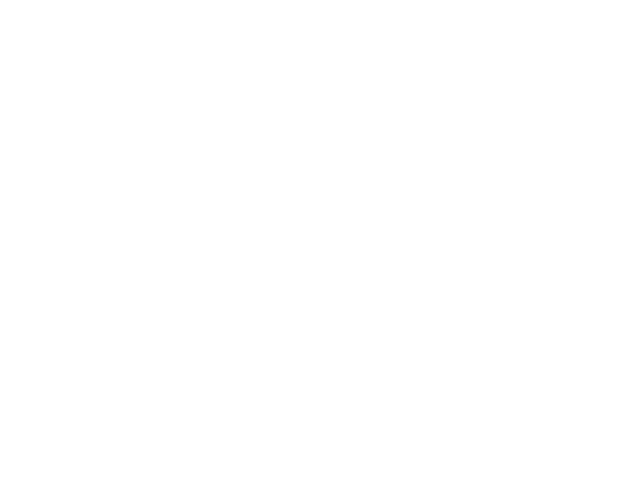

In [5]:
fig = plt.figure()  # Open the figure in the cell before the computing to see live changes

In [6]:
p = DM(update_object=True, update_probe=True, calc_llk=20, show_obj_probe=20)**100 * p
p = ML(update_object=True, update_probe=True, calc_llk=20, show_obj_probe=20)**100 * p

DM/o/3p    #  0 LLK=   485.42(p)  1687.88(g)   542.46(e), nb photons=8.865690e+09, dt/cycle= 3.6910s
DM/o/3p    # 20 LLK=     8.38(p)    30.01(g)    13.90(e), nb photons=8.323599e+09, dt/cycle= 0.0548s
DM/o/3p    # 40 LLK=     7.71(p)    23.32(g)    12.33(e), nb photons=8.297352e+09, dt/cycle= 0.0324s
DM/o/3p    # 60 LLK=     8.63(p)    15.18(g)    13.49(e), nb photons=8.280122e+09, dt/cycle= 0.0345s
DM/o/3p    # 80 LLK=     8.20(p)    17.55(g)    12.85(e), nb photons=8.294074e+09, dt/cycle= 0.0368s
DM/o/3p    # 99 LLK=     7.38(p)    29.00(g)    11.64(e), nb photons=8.310702e+09, dt/cycle= 0.0398s
ML/o/3p    #100 LLK=     6.84(p)    28.77(g)    10.91(e), nb photons=8.856738e+09, dt/cycle= 0.6876s
ML/o/3p    #120 LLK=     4.02(p)    38.21(g)     8.11(e), nb photons=8.882862e+09, dt/cycle= 0.0706s
ML/o/3p    #140 LLK=     3.58(p)    34.74(g)     7.38(e), nb photons=8.869336e+09, dt/cycle= 0.0726s
ML/o/3p    #160 LLK=     3.40(p)    33.92(g)     7.15(e), nb photons=8.861491e+09, dt/cycle

## Optimise object, probe and positions
This uses the AP and ML algorithms, which are more stable than DM for positions optimisations

Note the final improvement of the object near the center.

We use `pos_history=True` which will be used to plot the history of positions at the end, but this slows down the calculation as the values have to be grabbed from the GPU for each update. It's only useful to study how the algorithm works, in production it should not be used.

You can play with different parameters to tweak the position update and see how it affects the convergence:
* `update_pos=5`: update positions every N cycle. It's better for object and probe convergence to not update positions every cycle
* `pos_mult=5`: amplify the positions update. This speeds up the convergence, but can lead to unstabilities
* `pos_threshold=0.2`: this inhibits the positions update when the local object gradient \*probe is smaller than 0.2 times the average gradient for all positions. This prevents updating positions in areas of the object which are too smooth
* `min_shift`: don't update shifts when change is lower than a certain number of pixels (value has to be small as this is changes for a given cycle)
* `max_shift`: prevent too large changes per cycle. Should not be necessary, but can be safe

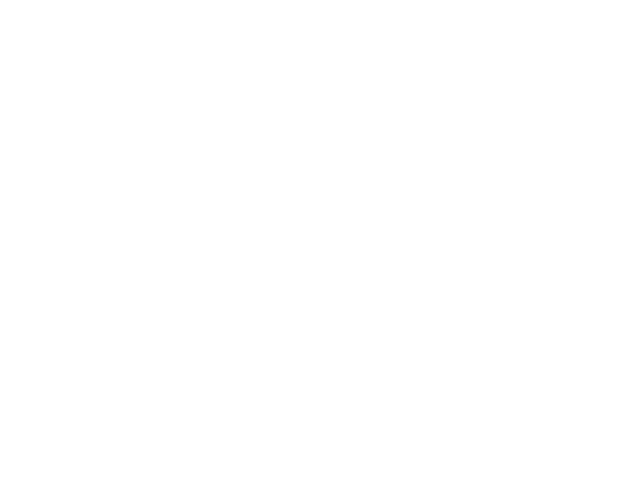

In [7]:
fig = plt.figure()

In [8]:
p = AP(update_object=True, update_probe=True, update_pos=5, pos_mult=5,
       pos_history=True, calc_llk=20, show_obj_probe=40)**200 * p
p = ML(update_object=True, update_probe=True, update_pos=5, pos_mult=5,
       pos_history=True, calc_llk=10, show_obj_probe=20)**100 * p


AP/o/3p/t  #200 LLK=     3.34(p)    33.60(g)     7.18(e), nb photons=8.859703e+09, dt/cycle= 8.7369s
AP/o/3p/t  #220 LLK=     2.84(p)    31.91(g)     5.59(e), nb photons=8.827095e+09, dt/cycle= 0.0273s
AP/o/3p/t  #240 LLK=     2.60(p)    32.23(g)     5.11(e), nb photons=8.820546e+09, dt/cycle= 0.0187s
AP/o/3p/t  #260 LLK=     2.50(p)    32.45(g)     4.92(e), nb photons=8.819710e+09, dt/cycle= 0.0331s
AP/o/3p/t  #280 LLK=     2.43(p)    33.22(g)     4.79(e), nb photons=8.817627e+09, dt/cycle= 0.0187s
AP/o/3p/t  #300 LLK=     2.39(p)    32.70(g)     4.71(e), nb photons=8.819716e+09, dt/cycle= 0.0296s
AP/o/3p/t  #320 LLK=     2.35(p)    32.56(g)     4.63(e), nb photons=8.819492e+09, dt/cycle= 0.0187s
AP/o/3p/t  #340 LLK=     2.34(p)    32.90(g)     4.61(e), nb photons=8.821839e+09, dt/cycle= 0.0317s
AP/o/3p/t  #360 LLK=     2.33(p)    32.28(g)     4.60(e), nb photons=8.820840e+09, dt/cycle= 0.0187s
AP/o/3p/t  #380 LLK=     2.31(p)    32.60(g)     4.55(e), nb photons=8.820161e+09, dt/cycle

## Plot the position shifts
This standard plot is also created when using the `analysis` step in the algorithm with the command-line scripts. 

Shifts are represented both with arrows (scaled if necessary) and a heat map relative to the maximum shift (the color indicates the direction of the shift, the intensity the relative amplitude).

In this case the piezo motors had some trouble in the center, either because of the slow start or the quick change of direction.

Average distance between points: 0.090765 µm
Shift in positions: mean=0.022716 µm, max=0.147741µm
Scale: 0.614354639367981


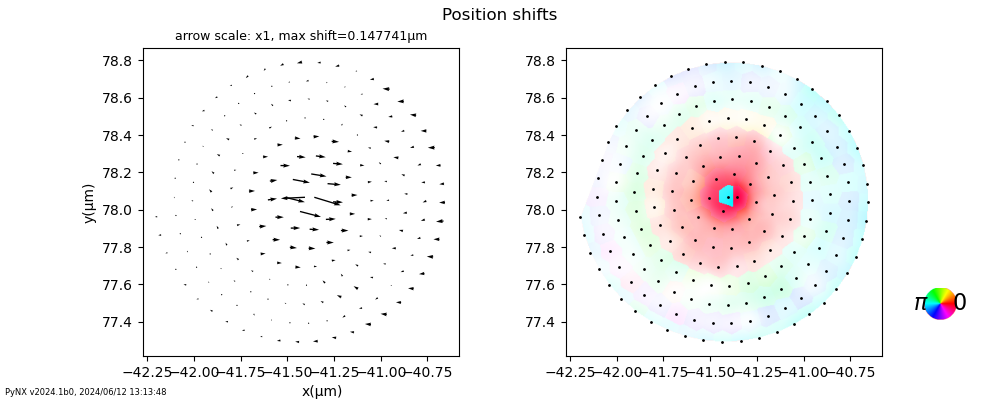

In [9]:
p = PlotPositions(show_plot=True, save_prefix=None, fig_size=(10,4)) * p

## Plot the history of position shifts near the center
We recorded the position history, so plot them for the center positions vs the cycle #. 

The position update parameters (e.g. `pos_mult`) can be modified to see how that affects convergence

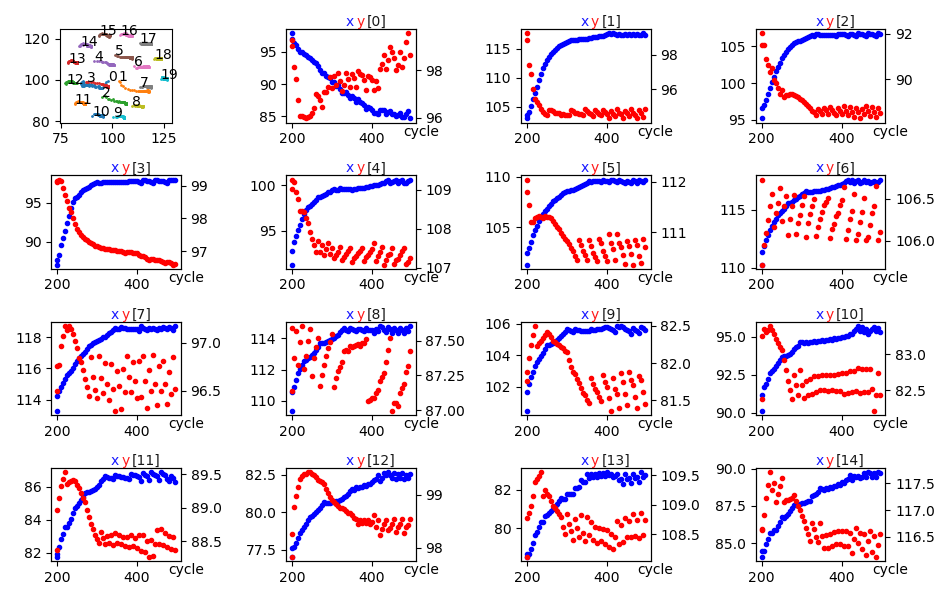

In [10]:
ipos = range(15)
fig = plt.figure(figsize=(9.5,6))
#ax = plt.axes((0.04,0.3,0.22,0.3))
plt.subplot(441)
#for i in range(default_processing_unit.get_stack_size()):
for i in range(20):
    x = [v[1] for v in p.position_history[i]]
    y = [v[2] for v in p.position_history[i]]
    plt.scatter(x,y, 1)
    plt.text(x[0], y[0], '%d' % i)
    #print("%3d  dr = %5.3f" % (i, np.sqrt((x[0]-x[-1])**2 + (y[0]-y[-1])**2)))
plt.gca().set_aspect(1)

for i in range(len(ipos)):
    #plt.subplot(4,4,2 + i // 3 * 4 + i % 3)
    plt.subplot(4,4,i+2)
    ix, x, y = [v[0] for v in p.position_history[ipos[i]]], [v[1] for v in p.position_history[ipos[i]]], \
               [v[2] for v in p.position_history[ipos[i]]]
    plt.plot(ix,x,'b.', label='x[%d]'%ipos[i])
    plt.twinx()
    plt.plot(ix,y,'r.', label='y[%d]'%ipos[i])
    plt.text(0.46, 1.03,'x', color='blue', alpha=0.9,transform=plt.gca().transAxes)
    plt.text(0.54, 1.03,'y', color='red', alpha=0.9,transform=plt.gca().transAxes)
    plt.text(0.62, 1.03,'[%d]'%ipos[i], alpha=0.9,transform=plt.gca().transAxes)
    plt.text(0.9, -.14, 'cycle',transform=plt.gca().transAxes)
plt.tight_layout()

## Free GPU memory
It is good practice in a notebook to use `FreePU()` to release memory from the GPU

In [11]:
p = FreePU() * p